# Deep Learning - Exercise 5

This lecture is about advanced topics of the CNN such as Autoencoder for image
reconstruction and Variatioanl autoencoder for generating images.

We use MNIST dataset for the tasks as it is quite easy to process.

**Core Concepts**

- 🖼️ Autoencoders for image reconstruction
- 🔀 Variational Autoencoders for image generation
- 🔢 MNIST dataset for image processing tasks
- ⚙️ Implementation of CNN-based autoencoders


[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_05.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_05.ipynb)

##### Remember to set **GPU** runtime in Colab!


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import os
import warnings

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir="
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

warnings.filterwarnings("ignore", category=UserWarning, module="keras")
warnings.filterwarnings("ignore", message="Unable to register cuDNN factory")
warnings.filterwarnings("ignore", message="Unable to register cuBLAS factory")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt  # plotting
import matplotlib.image as mpimg  # images
import numpy as np  # numpy
import tensorflow as tf
import tensorflow.keras as keras
import requests

from tensorflow.keras.layers import Activation, Layer
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19

from sklearn.model_selection import train_test_split  # split for validation sets
from sklearn.preprocessing import normalize  # normalization of the matrix
from scipy.signal import convolve2d  # convolutionof the 2D signals
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from PIL import Image
from io import BytesIO
from skimage.transform import resize
import cv2
import scipy
from tqdm.auto import tqdm, trange
from tqdm.notebook import tqdm, trange

tf.version.VERSION

2025-03-22 01:06:43.893843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742602003.911656   70653 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742602003.918389   70653 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


'2.18.0'

In [4]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()


def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i].reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i]])
    plt.show()

## 🔎 What is an autoencoder? 🔎

- The autoencoder is a special type of neural network that is able to learn
  without the classes just from the input data
  - It is equivalent to the feature extraction from the data
  - 🔎 Can you name any use-case for such model?
- What is the latent vector?
- How can we compare two images?

![Arch01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_05_enc_arch.png?raw=true)

## The autoencoder uses binary-crossentropy as loss function

- How is the function used?

$BCE = -\frac{1}{N}\sum_{i=1}^{N}y_i*log(p(y_i))+(1-y_i)*log(1-p(y_i))$

- 💡 Beware the asymetry of the BCE function

- **During the backpropagation process BCE cares more about very bright (1) or
  very dark pixels (0), but puts less effort on optimizing middle tones (0.5).**

- Give the true value is 0.2, and autoencoder A predicts 0.1 while autoencoder B
  predicts 0.3.

  - The loss for A would be:
    $−(0.2 * log_{10}(0.1) + (1−0.2) * log_{10}(1−0.2)) = 0.278$
  - The loss for B would be:
    $−(0.2 * log_{10}(0.3) + (1−0.2) * log_{10}(1−0.3)) = 0.228$

- 📌 Check
  [this](https://medium.com/towards-data-science/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)
  or
  [this](https://stats.stackexchange.com/questions/394582/why-is-binary-cross-entropy-or-log-loss-used-in-autoencoders-for-non-binary-da)
  for more details


# 🚀 Let's start!

- We will use _MNIST_ dataset again for this task


In [5]:
# mnist is the basic dataset for image classifaction
dataset = tf.keras.datasets.mnist

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x.reshape(*train_x.shape, 1)
test_x = test_x.reshape(*test_x.shape, 1)

train_x = train_x / 255.0
test_x = test_x / 255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 28x28 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = [str(x) for x in range(10)]
class_count = len(class_names)
print('Class count:', class_count, class_names)

Train data shape:  (48000, 28, 28, 1) (48000,)
Validation data shape:  (12000, 28, 28, 1) (12000,)
Test data shape:   (10000, 28, 28, 1) (10000,)
Class count: 10 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## I bet that you already remember the data 🙂


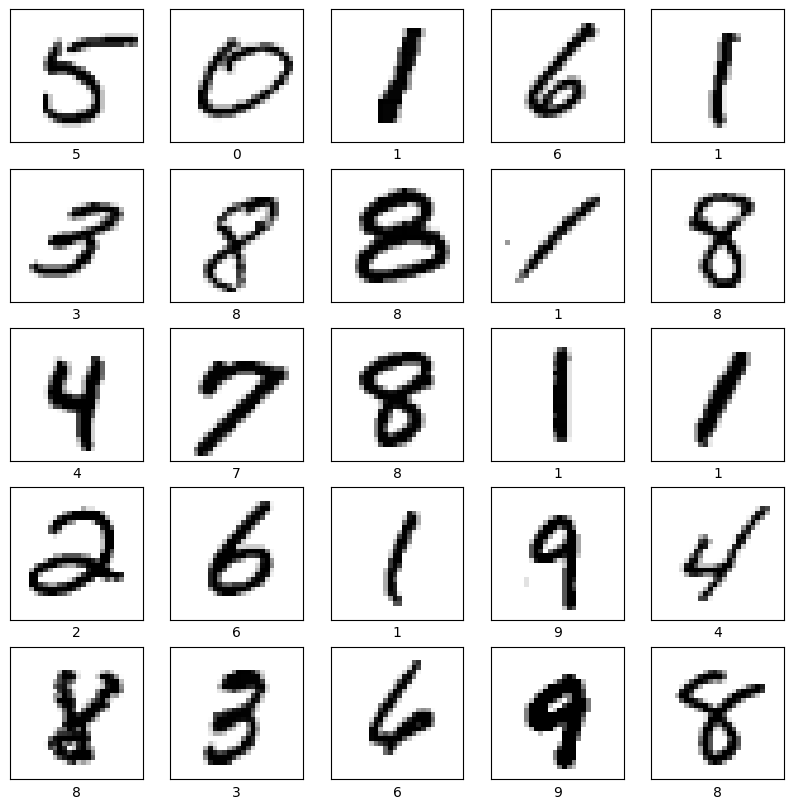

In [6]:
show_example(train_x, train_y, class_names)

## Extract single image shape


In [7]:
input_shape = train_x.shape[1:]
input_shape

(28, 28, 1)

## The autoencoder definition is really straightforward

- I hope that you would be able to define the architecture using the knowledge
  from previous lectures yourselves
  - 🔎 Why do we use `padding='same'`?
    - 💡 The convolutional layer will add padding to the input such that the
      output has the same width and height as the input
  - 🔎 Why do we have 128 numbers in the latent vector?
  - What does the `UpSampling2D` layer?
    - What interpolation methods do you know?


In [8]:
autoencoder = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    # a 128 values of the minimized knowledge / features
    keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.UpSampling2D((2, 2)),

    keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

autoencoder.summary()

autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

I0000 00:00:1742602007.904465   70653 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 8)        │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 32)       │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,409 (169.57 KB)

 Trainable params: 43,409 (169.57 KB)

 Non-trainable params: 0 (0.00 B)

## Fit the model


Epoch 1/10


I0000 00:00:1742602011.503901   70732 service.cc:148] XLA service 0x7f27dc004490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742602011.503940   70732 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
I0000 00:00:1742602011.884454   70732 cuda_dnn.cc:529] Loaded cuDNN version 90501


 16/375 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7588 - loss: 0.6039

I0000 00:00:1742602015.104244   70732 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.7950 - loss: 0.2685 - val_accuracy: 0.8051 - val_loss: 0.1283
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8078 - loss: 0.1227 - val_accuracy: 0.8109 - val_loss: 0.1122
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8104 - loss: 0.1106 - val_accuracy: 0.8109 - val_loss: 0.1065
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8118 - loss: 0.1046 - val_accuracy: 0.8112 - val_loss: 0.1022
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8119 - loss: 0.1005 - val_accuracy: 0.8124 - val_loss: 0.0982
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8128 - loss: 0.0975 - val_accuracy: 0.8130 - val_loss: 0.0960
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8127 - loss: 0.0958 - val_accuracy: 0.8136 - val_loss: 0.0948
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8131 - loss: 0.0939 - val_accuracy: 0.81

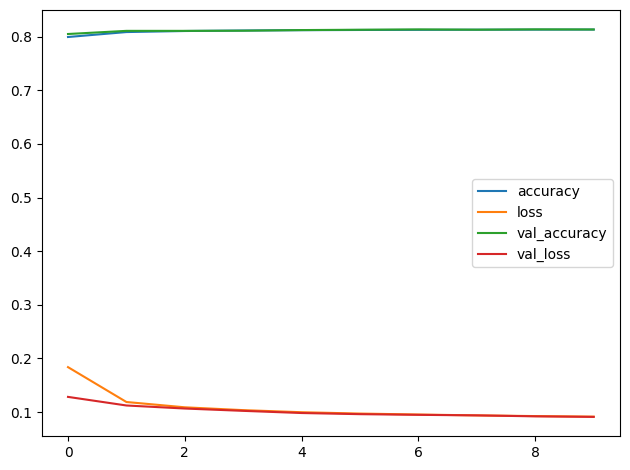

In [9]:
history = autoencoder.fit(train_x, train_x, validation_data=(valid_x, valid_x), epochs=10, batch_size=128)

show_history(history)

# Now you can generate original and reconstructed images

- ⚡ You feed-forward the test image set and the model will provide the
  reconstructed image on the output
- 🔎 How good is the reconstruction (just visually 🙂)?
  - On what parameter does the quality depend the most?
  - 🔎 Do you think the output is blurry?
    - Why?
    - Do you remember the BCE loss function caveat?
      - 💡 Take a look at the white pixels brightness 🙂


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


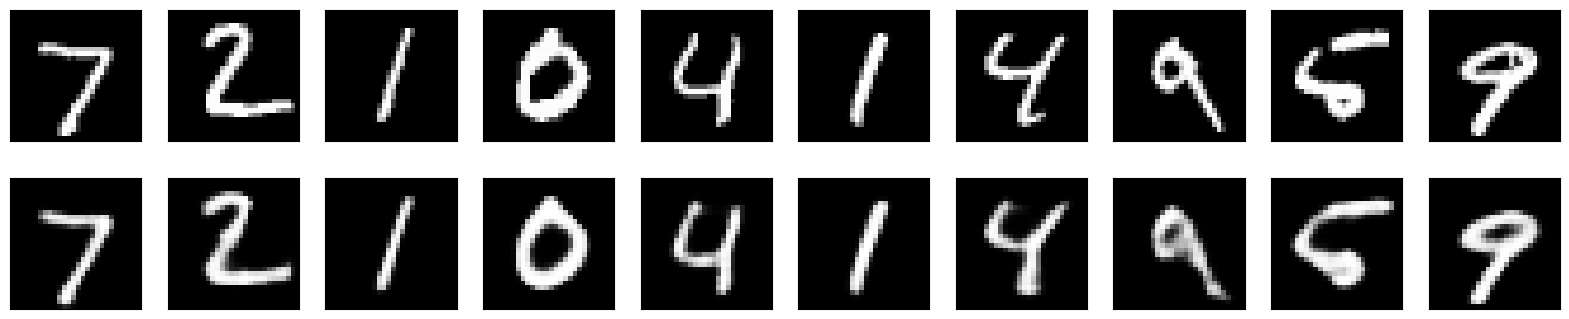

In [10]:
predicted = autoencoder.predict(test_x)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## We can also vizualize the encoded vectors

- We will just re-construct the encoder architecture and feed it with our
  pre-trained weights


In [11]:
encoder = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
])

# encoder.compile(optimizer='adam', loss='binary_crossentropy')
encoder.set_weights(autoencoder.get_weights()[:6])

for layer in encoder.layers:
    layer.trainable = False

encoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 8)        │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,416 (83.66 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,416 (83.66 KB)

## ⚡ Take a look at the latent vectors

- Do you see any differences among the vectors?
  - 💡 Compare vectors of _4_ to other *4*s and then compare vectors of *4*s to
    vectors of _1_


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


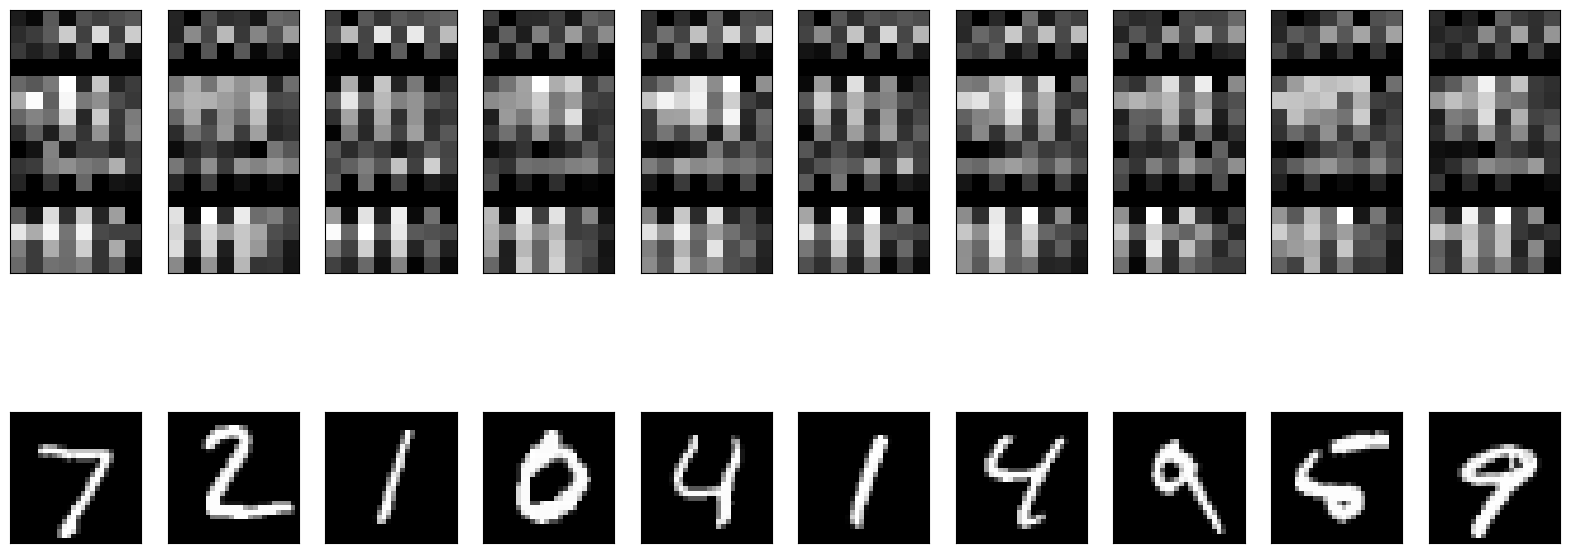

In [12]:
encoded = encoder.predict(test_x)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(encoded[i].reshape(8, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(test_x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Hey, but the classifier also has the latent vector after the encoder (CNN layers) part! 🤔

- The latent vector generated using the autoencoder principle generate a
  compressed representation of the input.
- Both models follow different set of goals and the goal of the autoencoder is
  different than from the classifier

  - 💡 Autoencoder want to compress the image into the latent vector in a way
    that it can be reconstructed with the best quality
  - 💡 Classifier want to embed the image into a latent vector as well, but the
    main goal is to create such representation that the vectors are different
    from each other so the model can distinguish among the images easily
  - 🔎 Which setting of the model has the biggest impact on the criterion?

- 💡 Some variants of encoder are able to generate better representation with
  some features - a sparse autoencoders that generate sparse representation for
  example.
  - 🔎 What is sparcity? Why would anyone want such property?

### Can we use latent vectors from just the **encoder** part of the autoencoder as a _feature engineering_ step for classifier? 🤔

- 💡 Yes, it is possible but given the different properties of the latent
  vectors, there would be a negative accuracy impact
- **TL;DR: Use classifiers for classification tasks and autoencoder for
  autoencoder tasks**


# Outlier Detection With Autoencoders

> ### 📌 If you cannot compress it, there is probably something wrong with it

- A classical obstacle you stumble upon in data science and machine learning are
  the outliers
- The concept of an outlier is intuitively clear to a human, yet there is no
  generally meaningful mathematical definition apart from simple hacks that
  involve the standard deviation or the interquartile range

- 💡 **By definition, outliers are not like other data points.**

![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_05_meme_01.png?raw=true)

- 🔎 Can you give some examples of an outlier in the data?

## How can we use autoencoders for the outlier detection?

- 💡 A good autoencoder should be able to compress (encode) data into fewer
  dimensions and then decompress (decode) it again without introducing many
  errors
  - An autoencoder tries to learn good encodings for a given dataset
  - 💡 Since most data points in the dataset are not outliers, the autoencoder
    will be influenced the most by "normal" data
- **📌 If the autoencoder introduces a large error for some data point, this
  data point might be an outlier**


## ⚡ We can test it out

- First, create sample dataset of 25 images


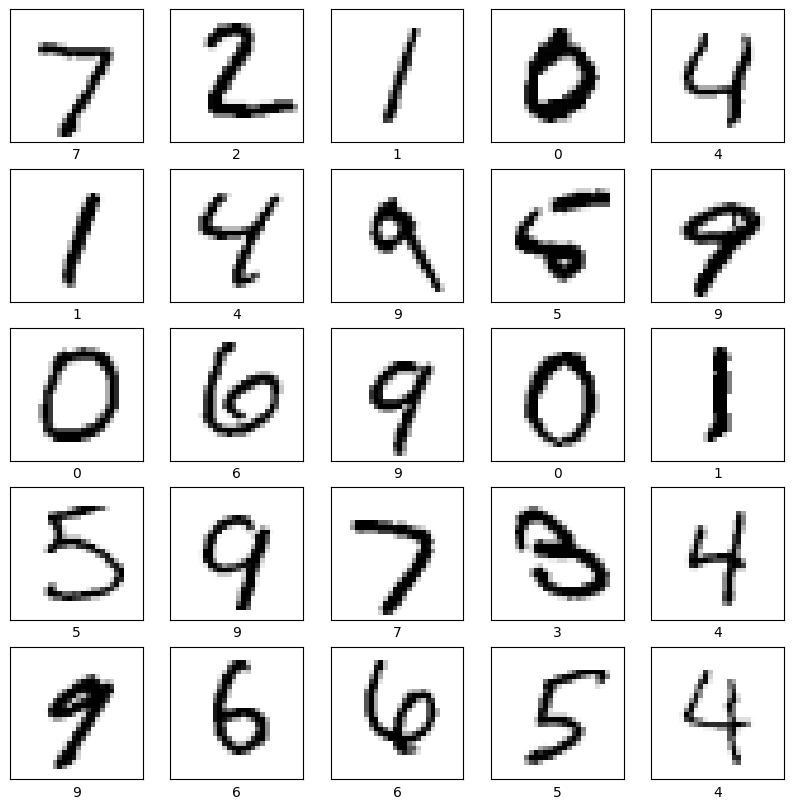

In [13]:
sample_x = test_x[:25]
sample_y = test_y[:25]

show_example(sample_x, sample_y, class_names)

## Now we will add a noise in the data to create the **outliers**


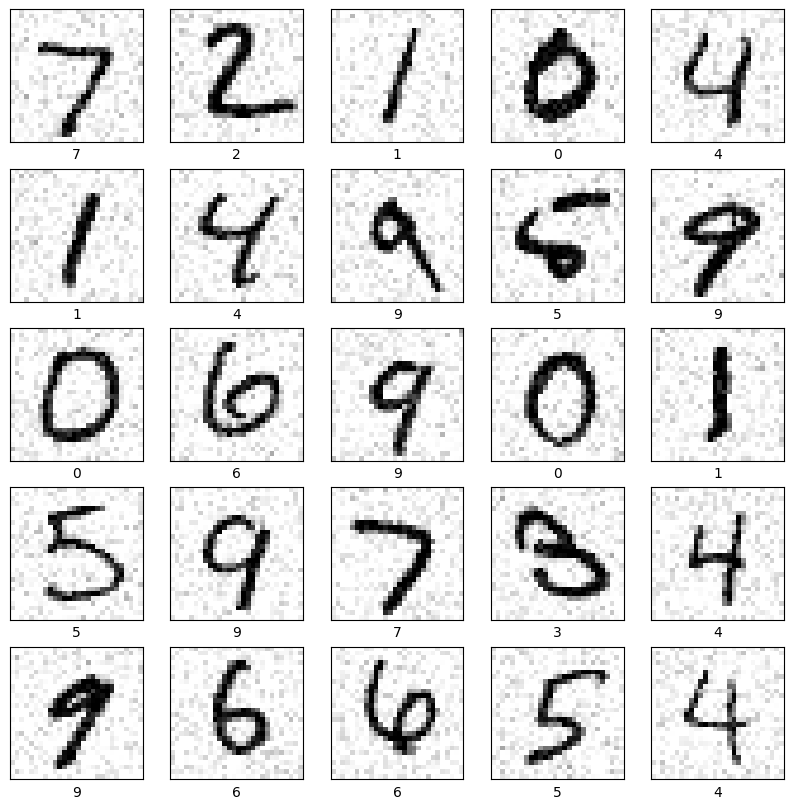

In [14]:
modified_x = np.clip(sample_x + 0.1 * np.random.normal(loc=0.0, scale=1.0, size=sample_x.shape), 0., 1.)
modified_y = sample_y
show_example(modified_x, modified_y, class_names)

## The first step is to create the reconstructed representation for the **original** samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


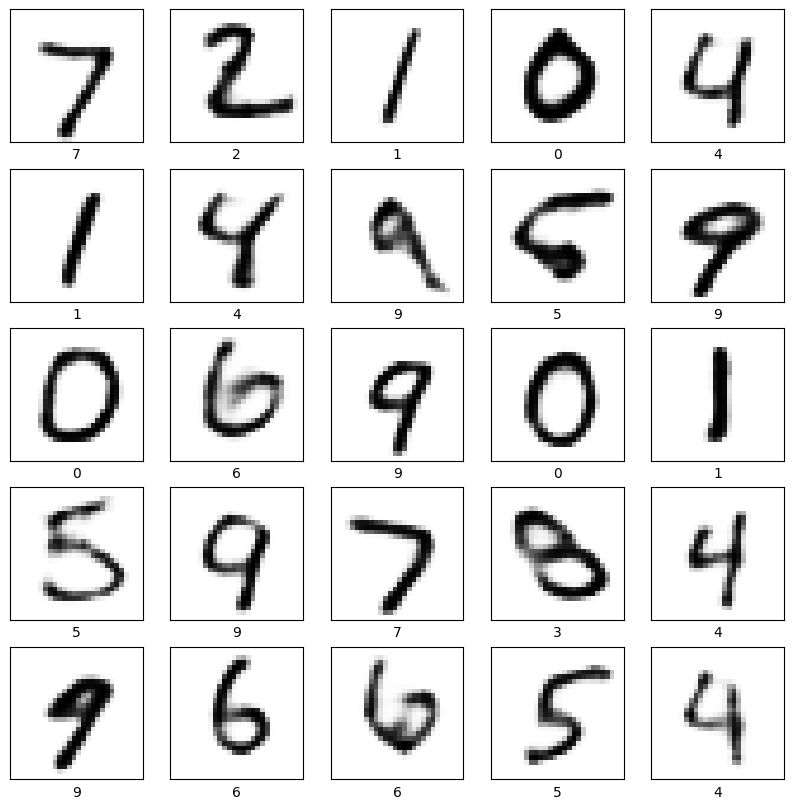

In [15]:
sample_predicted = autoencoder.predict(sample_x)
show_example(sample_predicted, sample_y, class_names)

## Then we will create the reconstructed representation for the **noisy** samples


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


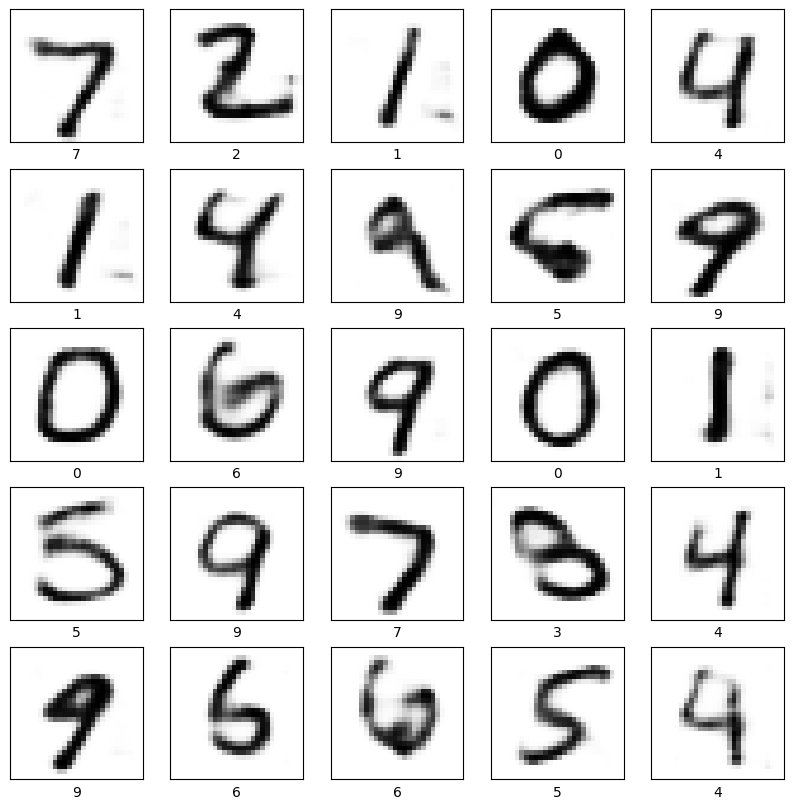

In [16]:
modified_pred = autoencoder.predict(modified_x)
show_example(modified_pred, modified_y, class_names)

## 🚀 Now we can compute the reconstruction errors for both of the image sets using Frobenius norm

- https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
- Frobenius norm (Euclidean norm) ~ Root of squared errors


In [17]:
sample_norms = [
    np.linalg.norm(
        sample_x[i].reshape(
            28,
            28) -
        sample_predicted[i].reshape(
                28,
                28)) for i in range(
                    len(sample_x))]
modified_norms = [
    np.linalg.norm(
        modified_x[i].reshape(
            28,
            28) -
        modified_pred[i].reshape(
                28,
                28)) for i in range(
                    len(sample_x))]

sample_mean, sample_std = np.mean(sample_norms), np.std(sample_norms)
modified_mean, modified_std = np.mean(modified_norms), np.std(modified_norms)

sample_mean, modified_mean

(np.float64(2.4733992507890177), np.float64(3.9521756608045))

## The final step is the visualization of the errors distribution

- 🔎 Can you see an outlier data in the plot?
  - How would you detect them?


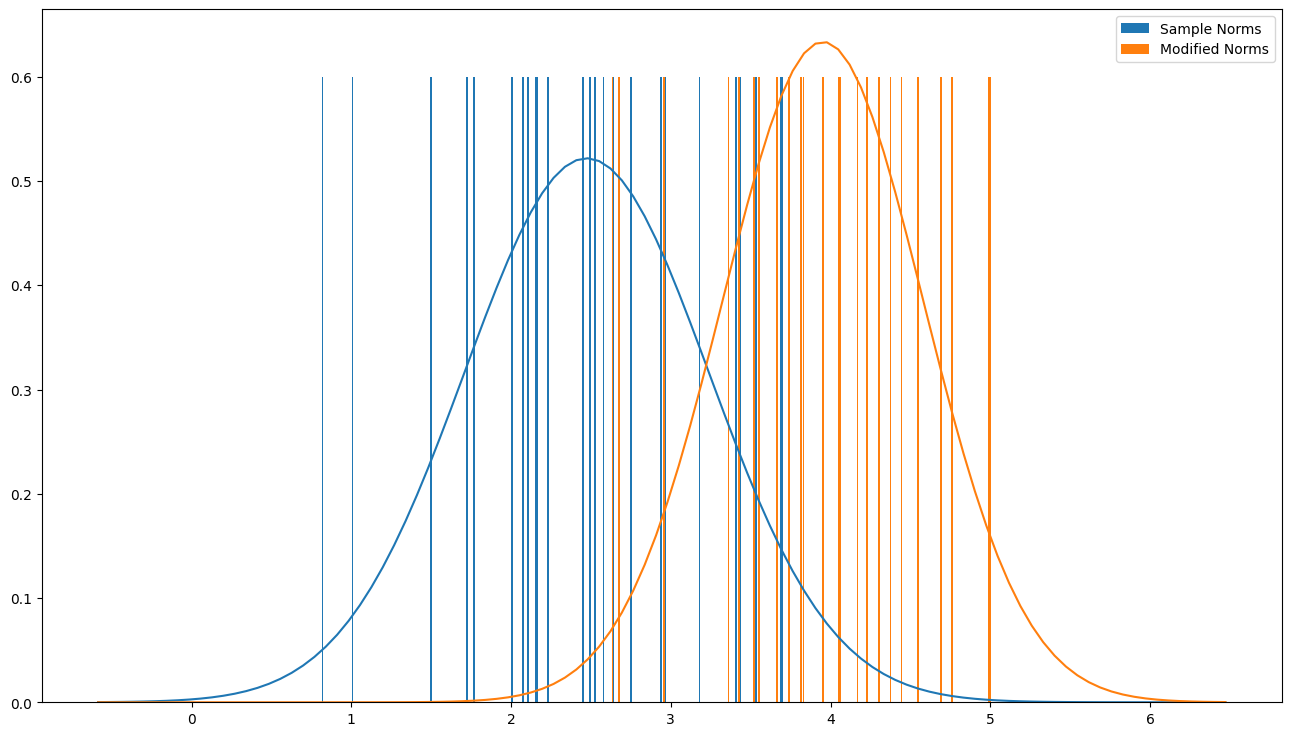

In [18]:
plt.figure(figsize=(16, 9))
xmin = np.min([sample_mean - 4 * sample_std, modified_mean - 4 * modified_std])
xmax = np.max([sample_mean + 4 * sample_std, modified_mean + 4 * modified_std])

x = np.linspace(xmin, xmax, 100)

y = scipy.stats.norm.pdf(x, sample_mean, sample_std)

plt.plot(x, y)

y = scipy.stats.norm.pdf(x, modified_mean, modified_std)

plt.plot(x, y)

plt.bar(x=sample_norms, height=[0.6 for x in sample_norms], width=0.01, label='Sample Norms')
plt.bar(x=modified_norms, height=[0.6 for x in modified_norms], width=0.01, label='Modified Norms')
plt.legend()
plt.show()

# 📒 Variational Autoencoder (VAE)

- A variational autoencoder (VAE) provides a probabilistic manner for describing
  an observation in latent space

- Rather than building an encoder which outputs a single value to describe each
  latent state attribute, we'll formulate our encoder to describe a probability
  distribution for each latent attribute

- 💡 Let's suppose we've trained an autoencoder model on a large dataset of
  faces with a encoding dimension of 6
  - An ideal autoencoder will learn descriptive attributes of faces such as skin
    color, whether or not the person is wearing glasses, etc. in an attempt to
    describe an observation in some compressed representation

![VAE01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_05_vae_01.png?raw=true)

- 📌 **Using a variational autoencoder, we can describe latent attributes in
  probabilistic terms**

![VAE02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_05_vae_02.png?raw=true)

![VAE03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_05_vae_03.png?raw=true)

- By constructing our encoder model to output a range of possible values (a
  statistical distribution) from which we'll randomly sample to feed into our
  decoder model, we're essentially enforcing a continuous, smooth latent space
  representation
  - 💡 For any sampling of the latent distributions, we're expecting our decoder
    model to be able to accurately reconstruct the input
  - 📌 Thus, values which are nearby to one another in latent space should
    correspond with very similar reconstructions

![VAE04](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_05_vae_04.png?raw=true)

- **You can see [this](https://www.jeremyjordan.me/variational-autoencoders/)
  for very good explanation**


## 🚀 Let's try it out!


## ⚠ There are some differences to the traditional classification task approach

- We will reshape data from 28x28 to 32x32x1 shape

  - We will use subsampling/pooling in the model so we expect division of width
    and height by 2 with each of the subsampling step
  - ⚠ Dividing 28 by 2 multiple times will lead to sequence ->
    `28 >> 14 >> 7 >> ...`
    - Number 7 could be an issue for reconstruction because the subsampling uses
      integer division (7 / 2 = 3) but 2\*3 = 6

- 💡 Resizing to 32x32 will save us from this issue because we will get sequence
  `32 >> 16 >> 8 >> 4 >> 2 >> 1` which is no problem to reconstruct

## ⚡ We will switch to PyTorch for a little while

- TF 2.18.0 + Keras 3 currently have some implementation issues with custom loss
  functions and sampling in feedforward phase
- Don't worry, the frameworks are not that different 😊


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

In [20]:
# Data preparation
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Sampling function will combine latent vector from encoder with samples from Normal (Gaussian) distribution ~ N(0, 1)


In [21]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch, dim = z_mean.shape
        epsilon = torch.randn(batch, dim, device=z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

# ⚡ Now we need to define the encoder and decoder part

- Input shape is equal to the latent dimensions count
- We use `ConvTranspose2d`, sometimes called de-conv layer
- A simple way of how to think about it is that it both performs the upsample
  operation and interprets the coarse input data to fill in the detail while it
  is upsampling
  - 💡 It is like a layer that combines the UpSampling2D and Conv2D layers into
    one layer
  - Models that use these layers can be referred to as deconvolutional networks,
    or deconvnets
- 📌 Unlike upsampling, it involves trainable parameters and **can learn to add
  new information** while increasing the size of the input

- A deconvnet can be thought of as a convnet model that uses the same components
  (filtering, pooling) but in reverse, so **instead of mapping pixels to
  features it does the opposite**

### `stride=2` in the `ConvTranspose2d` is responsible for the upsampling operation


In [22]:
class VAE(nn.Module):
    def __init__(self, input_shape=(32, 32, 1), latent_dim=16):
        super(VAE, self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(8 * 8 * 64, latent_dim)
        self.z_log_var = nn.Linear(8 * 8 * 64, latent_dim)
        self.sampling = Sampling()

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 8 * 8 * 64)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        return z_mean, z_log_var

    def decode(self, z):
        x = self.decoder_input(z)
        return self.decoder(x)

    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.sampling(z_mean, z_log_var)
        reconstructed = self.decode(z)
        return reconstructed, z_mean, z_log_var

## 💡 VAE uses specific loss function which we have to define ourselves

- The loss function combines RMSE with KL-divergence

  - KL divergence score, quantifies how much one probability distribution
    differs from another probability distribution.
    - https://machinelearningmastery.com/divergence-between-probability-distributions/
    - https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8

- We use the KL-divergence score to penalize the activation values of the mean
  and log_variance layers if they differ from N(0, 1) distribution
  - We want to be as close as possible to this distribution
  - 🔎 Why?


In [23]:
def vae_loss(recon_x, x, z_mean, z_log_var):
    # Reconstruction loss (BCE)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

    return recon_loss + kl_loss

# Set the latent vector dimension first

- Latent dimension define frow how many distributions we want to sample
- 💡 Each distribution a is Gaussian one, so we are creating basically
  multivariate Gaussian distribution


In [24]:
latent_dim = 2
epochs = 10

In [25]:
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
for epoch in trange(epochs):
    for batch_idx, (data, _) in tqdm(enumerate(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, z_mean, z_log_var = model(data)
        loss = vae_loss(recon_batch, data, z_mean, z_log_var)

        loss.backward()
        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## How will the reconstructed images look like?

- 🚀 Let's take a look!


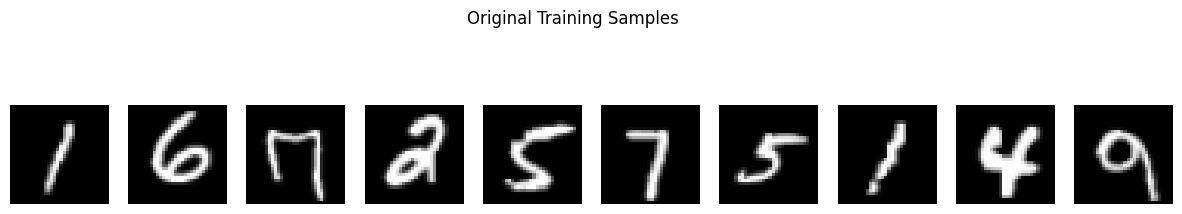

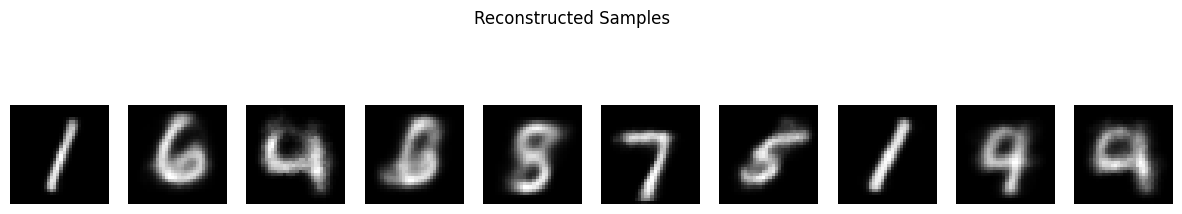

In [27]:
def show_images(images, n=10, title=None):
    plt.figure(figsize=(15, 3))
    images = images.cpu().detach().numpy()
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    if title:
        plt.suptitle(title)
    plt.show()


# Display sample training images
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
batch, _ = next(iter(train_loader))
show_images(batch, title="Original Training Samples")

# Display reconstructed images after training
with torch.no_grad():
    reconstructed, _, _ = model(batch.to(device))
show_images(reconstructed, title="Reconstructed Samples")

# 🔎 We can see that the images are too noisy, what can we do about it?


## How can we use VAE for creating new images? 🤔

- If we use just the decoder part of the model and feed it samples from
  distribution N(0, 1) we can generate new images with the model!


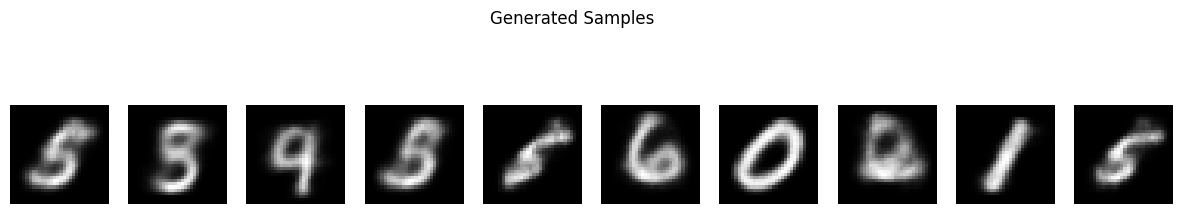

In [28]:
# Display generated samples
with torch.no_grad():
    z = torch.randn(10, 2).to(device)
    generated = model.decode(z)
show_images(generated, title="Generated Samples")

## 📈 We can display even the whole manifold

- 🔎 How can we select scale?

- 💡 3-sigma rule is helpful!

  - 𝑃(𝜇 − 𝑘𝜎 < 𝑋 < 𝜇 + 𝑘𝜎) = 0.954 for k=2
  - k = 2, 𝜇 = 0, 𝜎 = 1 in our case so 95,4% of numbers will be in interval <-2,
    2>

- Make sure your `latent_dim` is 2 for 2D visualization!


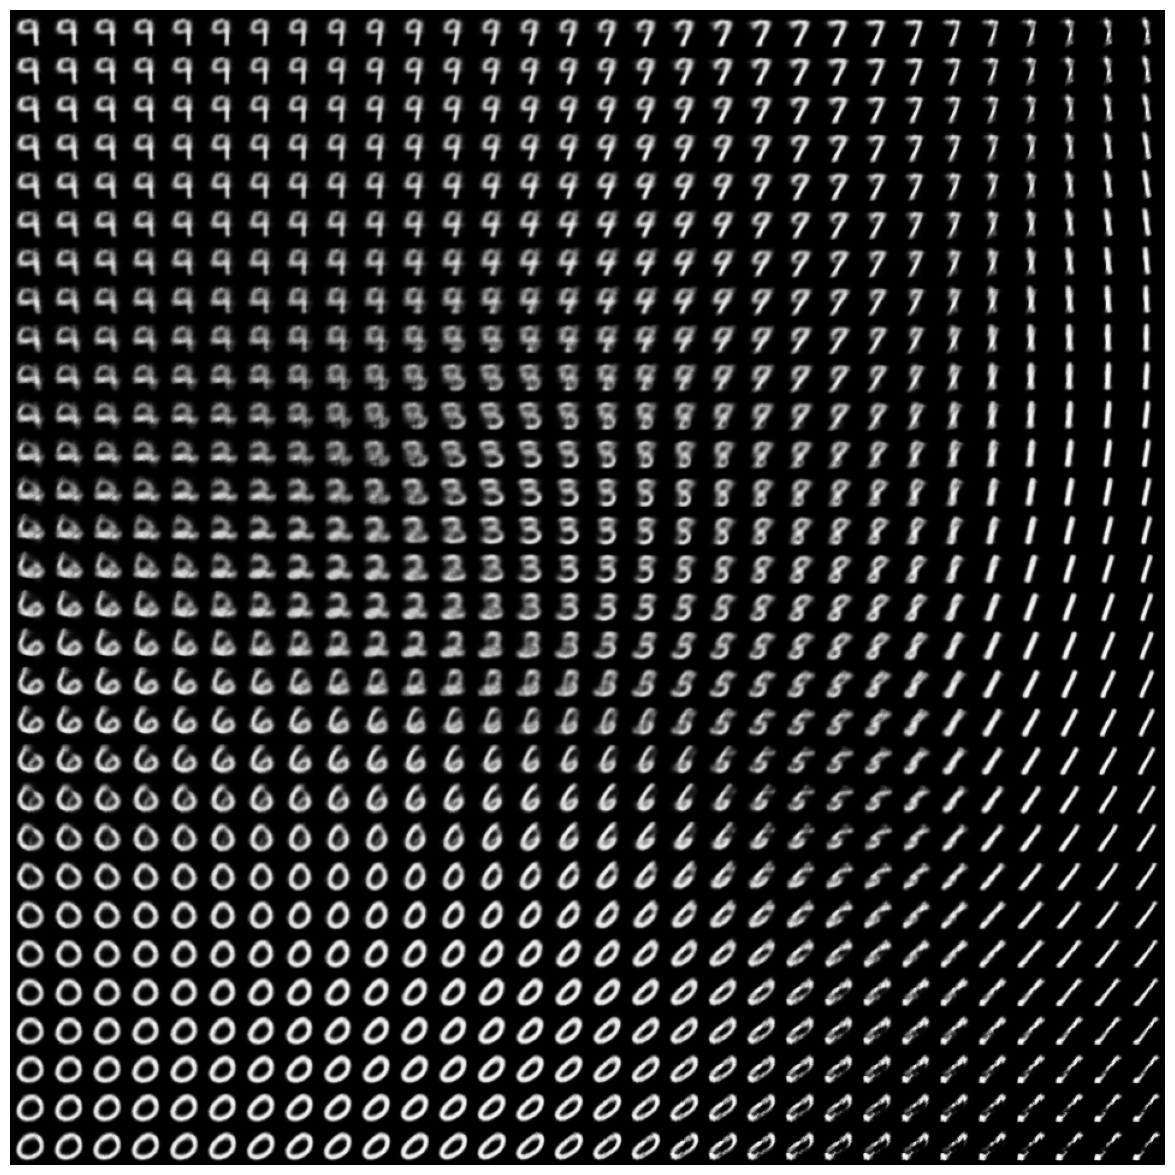

In [29]:
def plot_latent(decoder, device='cuda', n=30, scale=2.0):
    # Display n*n 2D manifold of digits
    digit_size = 32
    figsize = 15

    with torch.no_grad():
        # Create grid in latent space
        grid_x = torch.linspace(-scale, scale, n)
        grid_y = torch.linspace(-scale, scale, n).flipud()

        # Initialize figure
        figure = torch.zeros((digit_size * n, digit_size * n))

        # Generate images for each grid point
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                # Create latent vector sample
                z_sample = torch.tensor([[xi.item(), yi.item()]], device=device)

                # Generate image
                x_decoded = decoder(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size).cpu()

                # Add to figure
                figure[
                    i * digit_size: (i + 1) * digit_size,
                    j * digit_size: (j + 1) * digit_size
                ] = digit

    # Plot the results
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('off')
    plt.show()


# Usage (make sure your latent_dim is 2 for 2D visualization)
plot_latent(model.decode, device=device)

# ✅ Tasks for the lecture (2p)

- Implement an autoencoder model that is able to denoise an image

  - 💡 Implement it on the data defined below

- The denoising autoencoder is an autoencoder that will learn how to remove
  random noise from the images
  - First, noisy images have to be generated
  - Then the autoencoder need to be defined and trained
  - In the end, denoised images may be reconstructed
- Experiment with **noise_factor** values of `0.1`, `0.5` and `0.9`
  - 📒Write down a short summary about the reconstruction capabilities of the
    model


In [30]:
dataset = tf.keras.datasets.mnist
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x.reshape(*train_x.shape, 1)
test_x = test_x.reshape(*test_x.shape, 1)

train_x = train_x / 255.0
test_x = test_x / 255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = [str(x) for x in range(10)]
class_count = len(class_names)
print('Class count:', class_count, class_names)

Train data shape:  (48000, 28, 28, 1) (48000,)
Validation data shape:  (12000, 28, 28, 1) (12000,)
Test data shape:   (10000, 28, 28, 1) (10000,)
Class count: 10 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


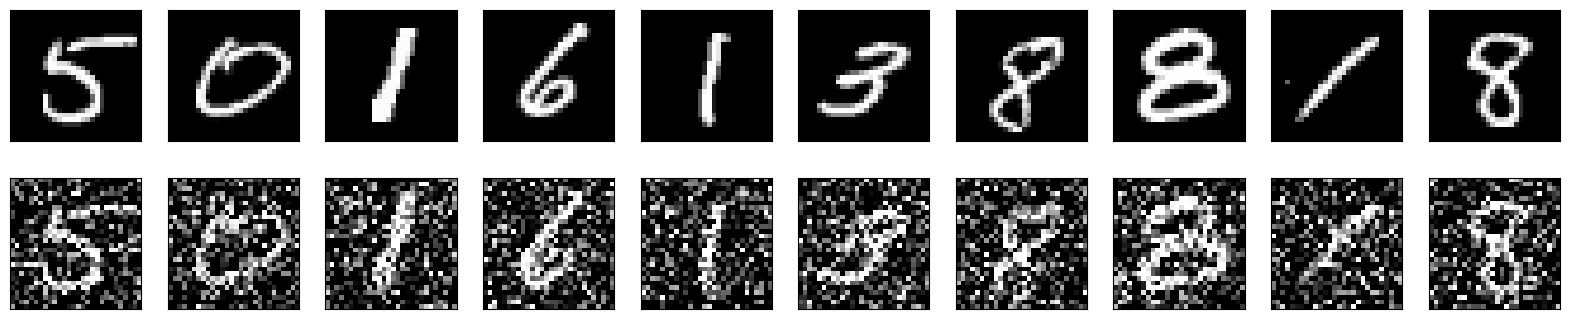

In [31]:
noise_factor = 0.5
noisy_train_x = np.clip(train_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape), 0., 1.)
noisy_valid_x = np.clip(valid_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_x.shape), 0., 1.)
noisy_test_x = np.clip(test_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_x.shape), 0., 1.)


n = 10
plt.figure(figsize=(2 * n, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(noisy_train_x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 🛠️ Task 1 - Implement an autoencoder model that is able to denoise an image

## 🔍 Extracting Input Shape for Model Configuration


In [32]:
input_shape = train_x.shape[1:]

## 🤖 Define the Autoencoder Model


In [33]:

def build_denoiser():
    model = keras.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        keras.layers.MaxPooling2D((2, 2), padding='same'),
        keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D((2, 2), padding='same'),
        keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D((2, 2), padding='same'),

        keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu'),

        keras.layers.UpSampling2D((2, 2)),
        keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        keras.layers.UpSampling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.UpSampling2D((2, 2)),
        keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

### 🛠️ Denoiser Model Architecture

- **Input Layer**:
  - `Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape)`
    🌟
- **Downsampling**:
  - `MaxPooling2D((2, 2), padding='same')` 🔽
  - `Conv2D(32, (3, 3), padding='same', activation='relu')` 🎨
  - `MaxPooling2D((2, 2), padding='same')` 📉
  - `Conv2D(8, (3, 3), padding='same', activation='relu')` 🧩
  - `MaxPooling2D((2, 2), padding='same')` ⏬
- **Bottleneck**:
  - `Conv2D(8, (3, 3), padding='same', activation='relu')` 🌀
- **Upsampling**:
  - `UpSampling2D((2, 2))` ⏫
  - `Conv2D(32, (3, 3), padding='same', activation='relu')` 🖌️
  - `UpSampling2D((2, 2))` 📈
  - `Conv2D(64, (3, 3), activation='relu')` 🎯
  - `UpSampling2D((2, 2))` 🚀
- **Output Layer**:
  - `Conv2D(1, (3, 3), activation='sigmoid', padding='same')` 🖼️
- **Compilation**:
  - `optimizer='adam', loss='binary_crossentropy'` ⚙️


## 🔊 Define Noise Factor Range


In [34]:
noise_factors = np.arange(0.1, 1.0, 0.2)
results = {}
epochs = 10
batch_size = 64

## 🎨 Generate Noisy Images, Train the Model, and Reconstruct the Images


### 📊 Precompute Noisy Datasets


In [35]:
noisy_data = {}
for noise_factor in noise_factors:
    noisy_data[noise_factor] = {
        'train': np.clip(train_x + noise_factor * np.random.normal(size=train_x.shape), 0, 1),
        'valid': np.clip(valid_x + noise_factor * np.random.normal(size=valid_x.shape), 0, 1),
        'test': np.clip(test_x + noise_factor * np.random.normal(size=test_x.shape), 0, 1)
    }

## 🏗️ Build the Model Once


In [36]:
model = build_denoiser()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 8)        │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 4, 4, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 32)       │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,409 (169.57 KB)

 Trainable params: 43,409 (169.57 KB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Train the Model


In [37]:
for noise_factor in tqdm(noise_factors, desc="Training for Noise Factors", position=0):
    noisy_train = noisy_data[noise_factor]['train']
    noisy_valid = noisy_data[noise_factor]['valid']
    noisy_test = noisy_data[noise_factor]['test']

    # Reset model weights (if needed)
    model.set_weights(build_denoiser().get_weights())

    # Train model
    for epoch in tqdm(range(epochs), desc=f"Training for Noise Factor {noise_factor:.1f}", leave=False, position=1):
        model.fit(noisy_train, train_x,
                  epochs=1,
                  batch_size=batch_size,
                  validation_data=(noisy_valid, valid_x),
                  verbose=0)

    # Store results
    denoised = model.predict(noisy_test[:10])
    results[noise_factor] = {
        'noisy': noisy_test[:10],
        'denoised': denoised,
        'test_loss': model.evaluate(noisy_test, test_x, verbose=0)
    }

Training for Noise Factors:   0%|          | 0/5 [00:00<?, ?it/s]

Training for Noise Factor 0.1:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


Training for Noise Factor 0.3:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Training for Noise Factor 0.5:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Training for Noise Factor 0.7:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Training for Noise Factor 0.9:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


## 📊 Visualize the Results


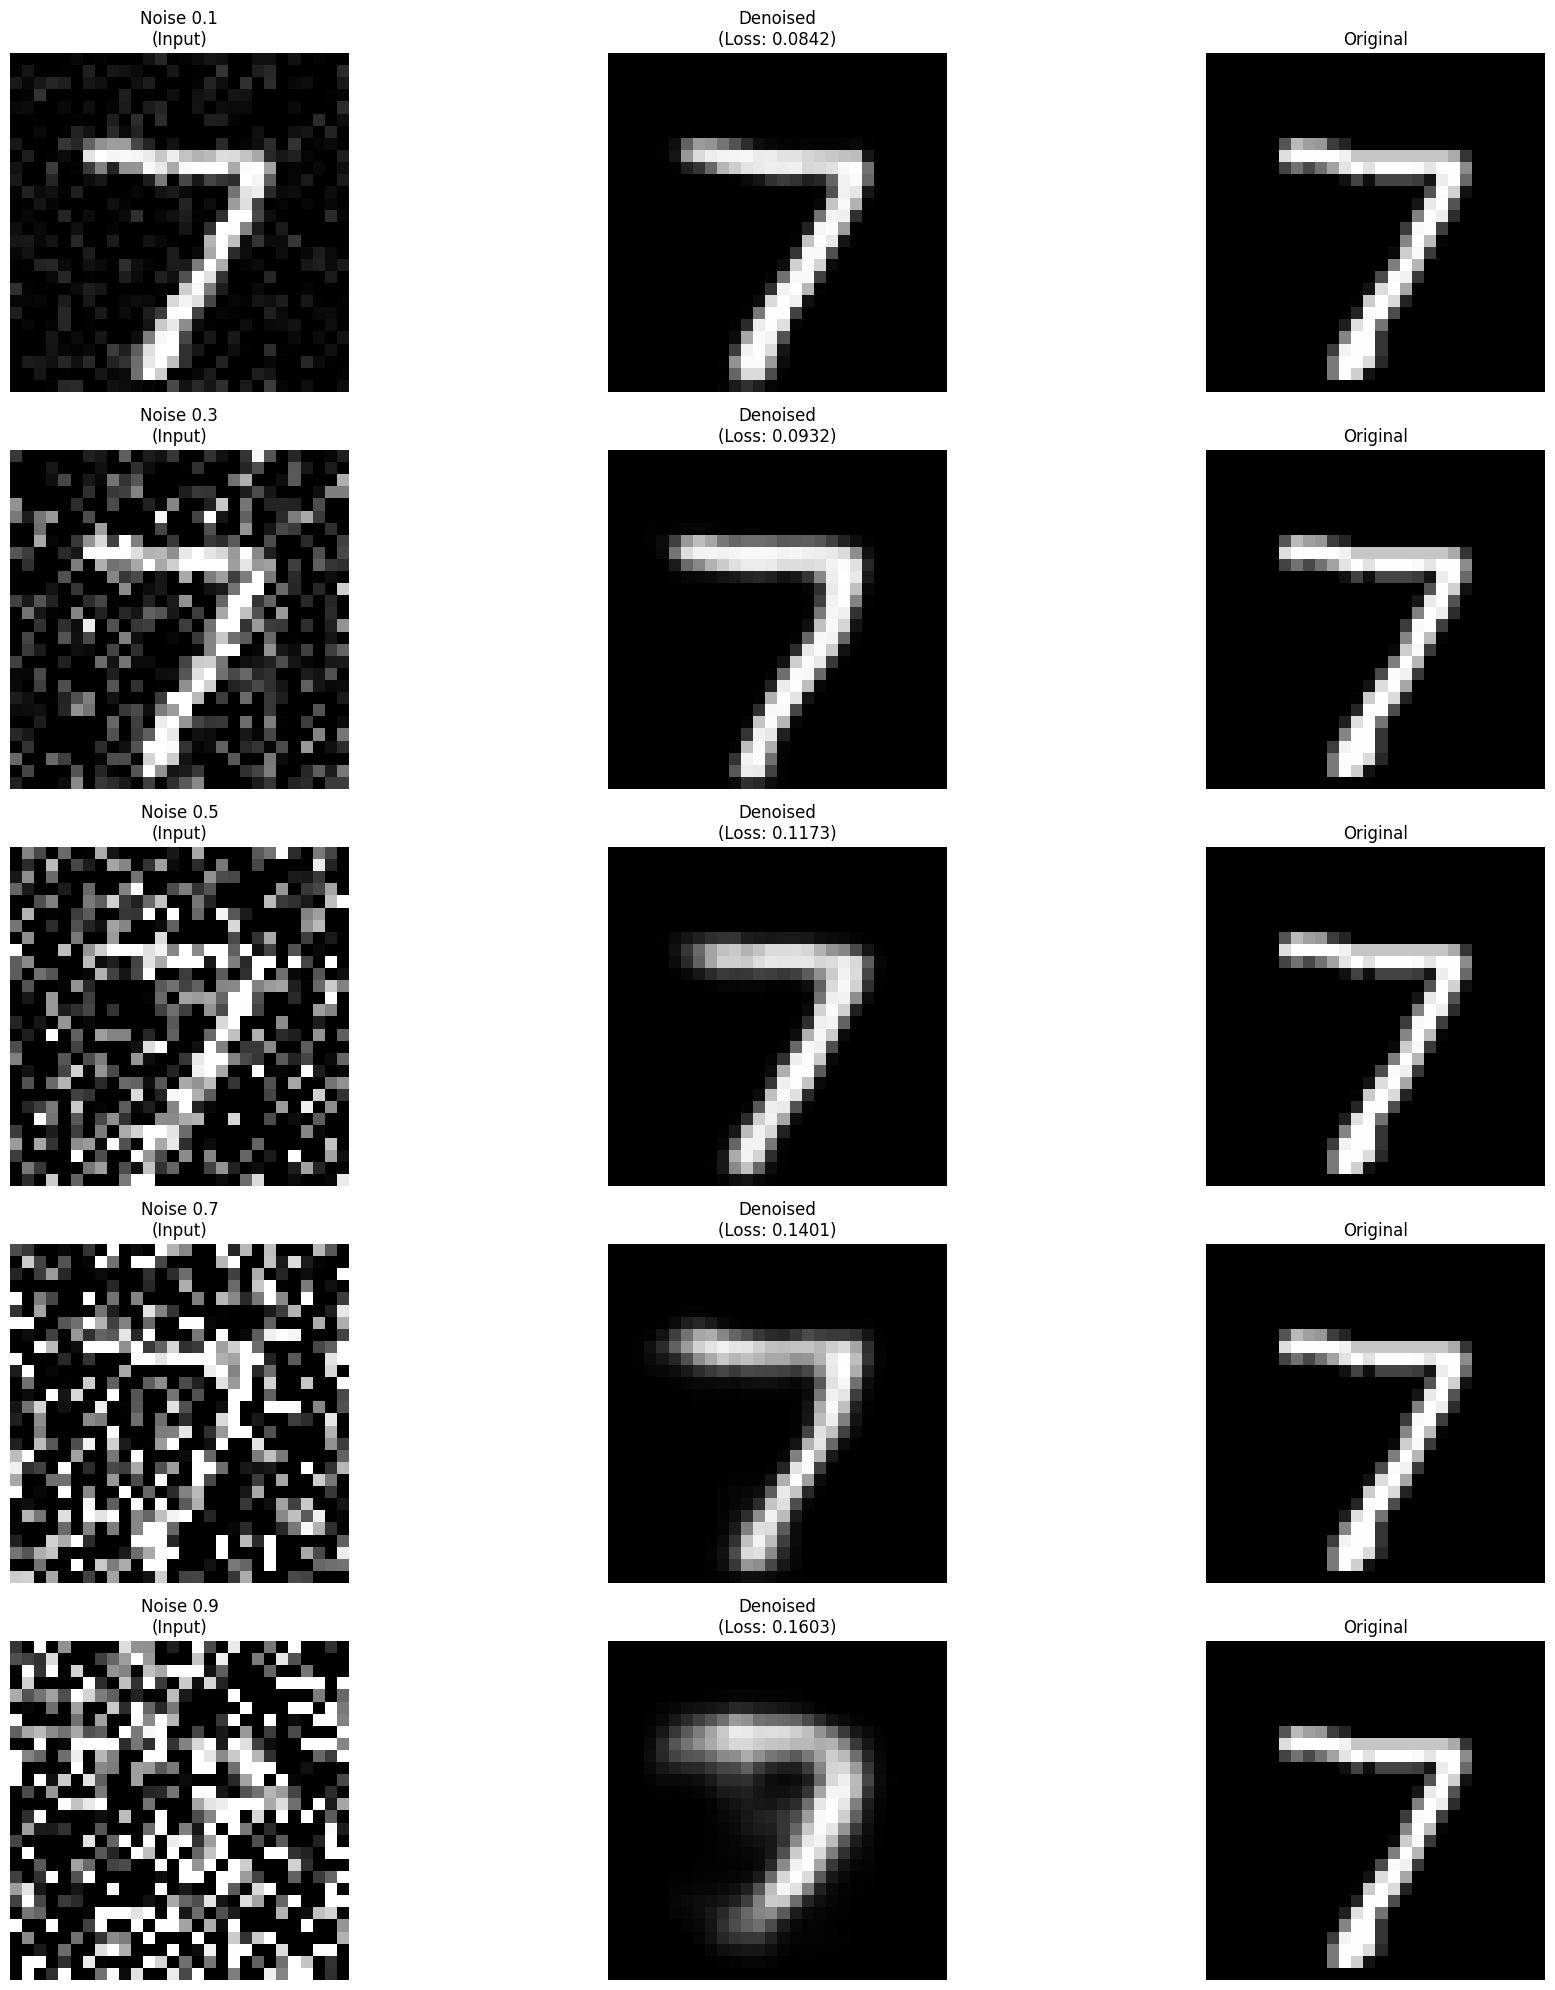

In [ ]:
plt.figure(figsize=(20, len(noise_factors) * 4))
for idx, noise_factor in enumerate(noise_factors):
    plt.subplot(len(noise_factors), 3, idx * 3 + 1)
    plt.imshow(results[noise_factor]['noisy'][0].squeeze(), cmap='gray')
    plt.title(f"Noise {noise_factor:.1f}\n(Input)")
    plt.axis('off')

    plt.subplot(len(noise_factors), 3, idx * 3 + 2)
    plt.imshow(results[noise_factor]['denoised'][0].squeeze(), cmap='gray')
    plt.title(f"Denoised\n(Loss: {results[noise_factor]['test_loss']:.4f})")
    plt.axis('off')

    plt.subplot(len(noise_factors), 3, idx * 3 + 3)
    plt.imshow(test_x[0].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()